# Earthquake data preprocessing

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data *within* each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, you should predict a *single* `time_to_failure` corresponding to the time between the *last row of the segment* and the next laboratory earthquake.

# Links

Data description: https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Additional info: https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526

In [1]:
import os, sys
import os.path as osp
import pandas as pd
import numpy as np
from glob import glob
import tqdm
import shutil
import time

from multiprocessing import Process, Queue
import tensorflow as tf  # for writing TFRecords

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir('/workspace/persistent-data/earthquake/')

In [3]:
def timestamp():
    return time.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
QUAKES = 'train/train.csv'

In [5]:
# quakes = pd.read_csv(QUAKES, header=0, names=['acoustic_data', 'time_to_failure'],
#                      dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
#                      engine='c', compression=None, low_memory=False)

In [6]:
# # Save to pickle for faster reading later
# quakes.to_pickle('train/train.pickle')

In [7]:
quakes = pd.read_pickle('train/train.pickle')

In [6]:
quakes.shape

(629145480, 2)

In [7]:
quakes.head(3)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691


In [8]:
quakes.dtypes

acoustic_data        int16
time_to_failure    float64
dtype: object

# Feature histograms

In [8]:
def hist(data, title=None, bins=100):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.hist(data, bins=100)
    if title is None:
        try:
            title = data.name
        except:
            title = 'histogram generated at %s' % timestamp()
    ax.set_title(title)
    plt.show()

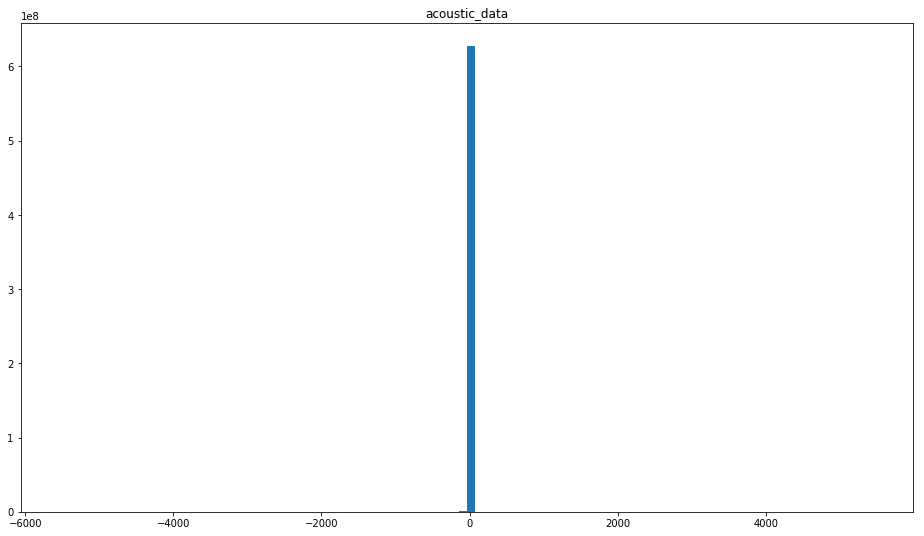

In [24]:
hist(quakes['acoustic_data'])

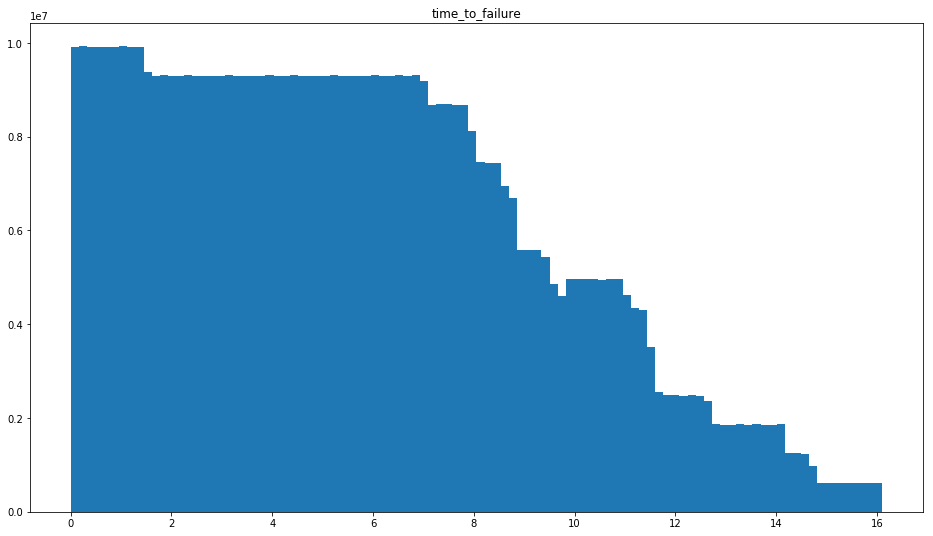

In [25]:
hist(quakes['time_to_failure'])

# Feature plots over time

In [16]:
def line_plot(x, y, title=None, linewidth=0.5, reversex=False):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(x, y, linewidth=linewidth)
    if title is None:
        try:
            title = x.name + ' vs. ' + y.name
        except:
            title = 'line_plot generated at %s' % timestamp()
    ax.set_title(title)
    if reversex:
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[1], xlim[0])
    plt.show()

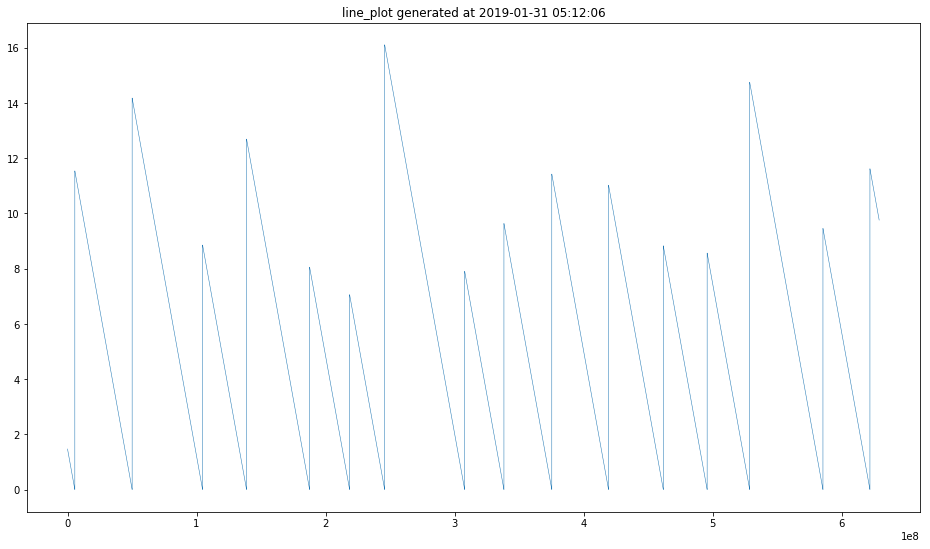

In [29]:
line_plot(range(len(quakes)), quakes['time_to_failure'])

In [12]:
quake_indexes = np.where(quakes['time_to_failure'].diff() > 0)[0]

In [13]:
quake_indexes = list(zip([0] + quake_indexes.tolist(), quake_indexes.tolist() + [len(quakes)]))

In [14]:
print('\n'.join(map(lambda x: 'Earthquake %d:\t%s' % (x[0] + 1, x[1]), enumerate(quake_indexes))))

Earthquake 1:	(0, 5656574)
Earthquake 2:	(5656574, 50085878)
Earthquake 3:	(50085878, 104677356)
Earthquake 4:	(104677356, 138772453)
Earthquake 5:	(138772453, 187641820)
Earthquake 6:	(187641820, 218652630)
Earthquake 7:	(218652630, 245829585)
Earthquake 8:	(245829585, 307838917)
Earthquake 9:	(307838917, 338276287)
Earthquake 10:	(338276287, 375377848)
Earthquake 11:	(375377848, 419368880)
Earthquake 12:	(419368880, 461811623)
Earthquake 13:	(461811623, 495800225)
Earthquake 14:	(495800225, 528777115)
Earthquake 15:	(528777115, 585568144)
Earthquake 16:	(585568144, 621985673)
Earthquake 17:	(621985673, 629145480)


# Plot acoustic activity over time for each earthquake separately

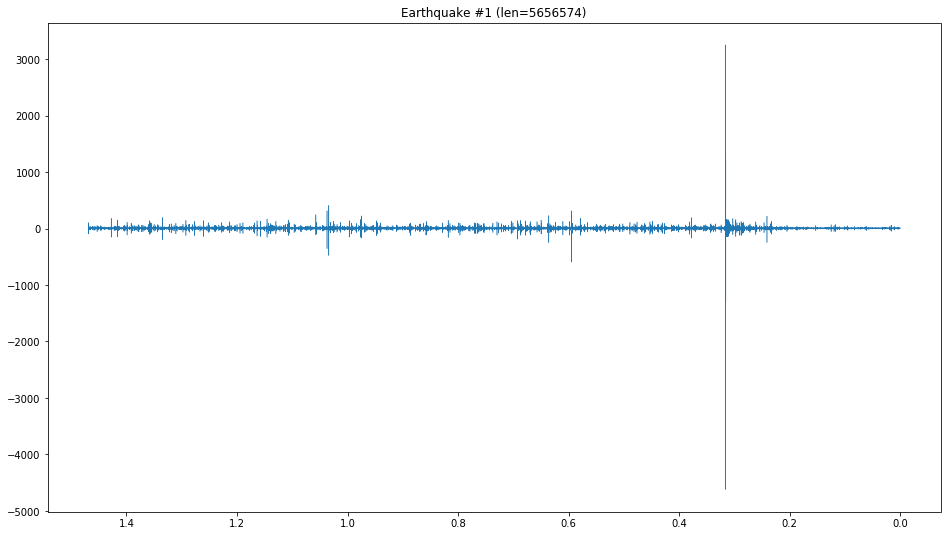

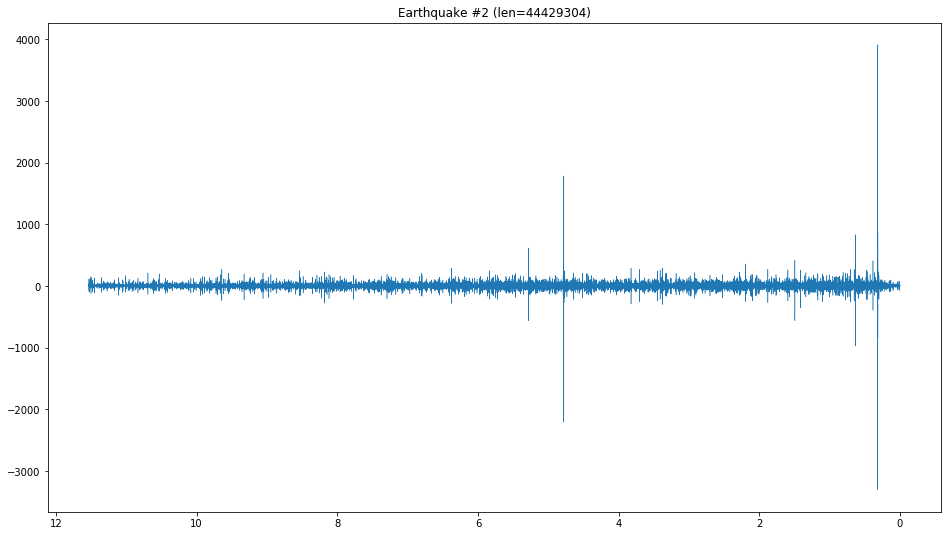

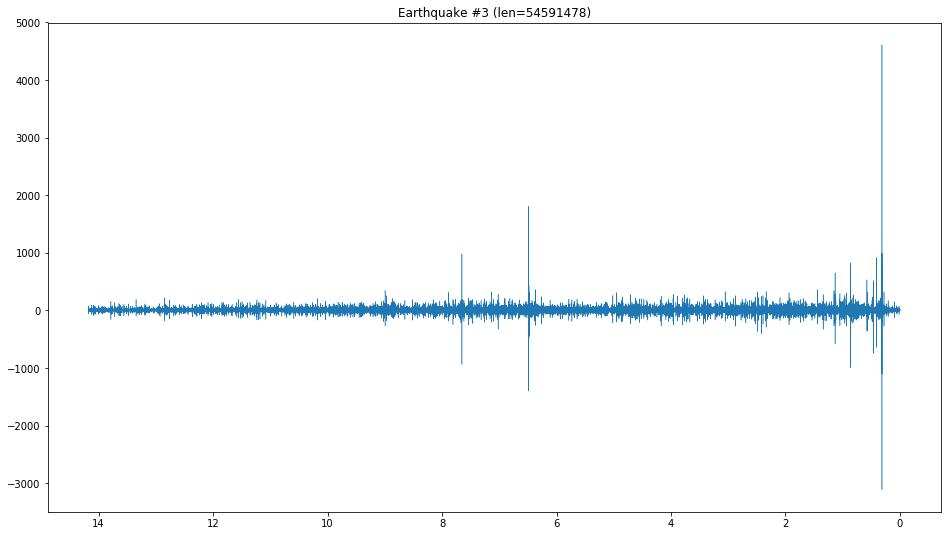

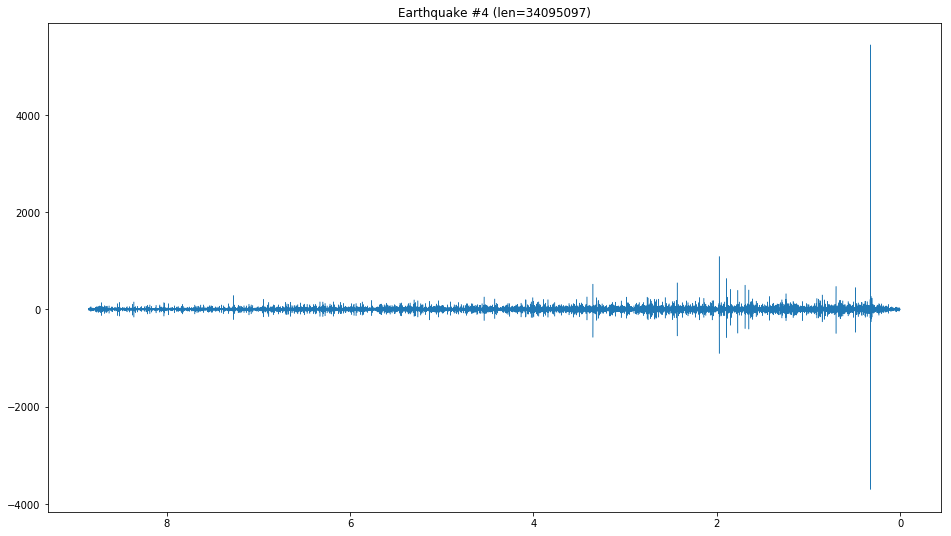

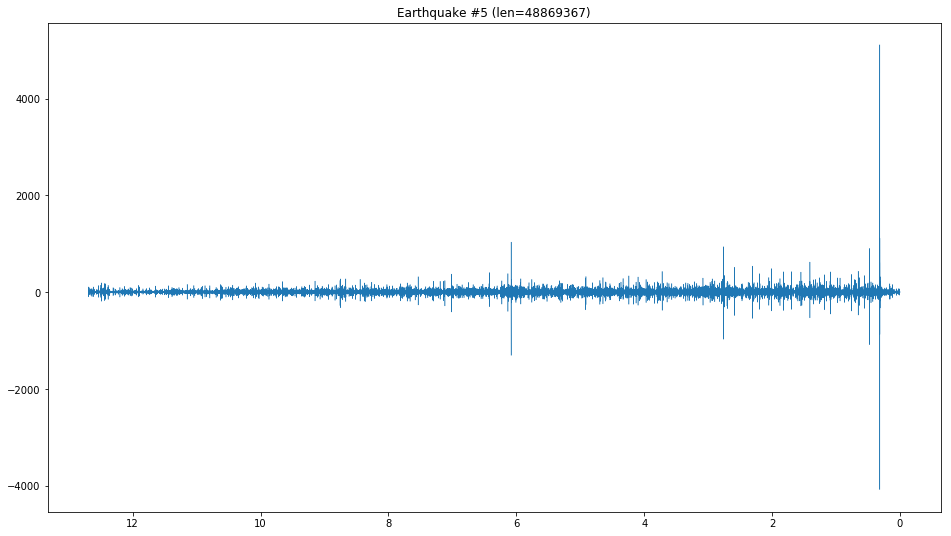

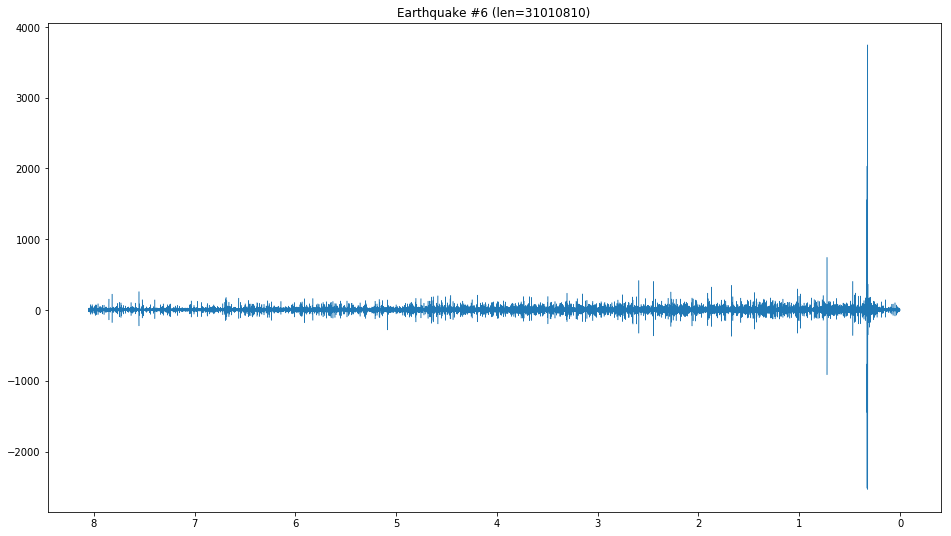

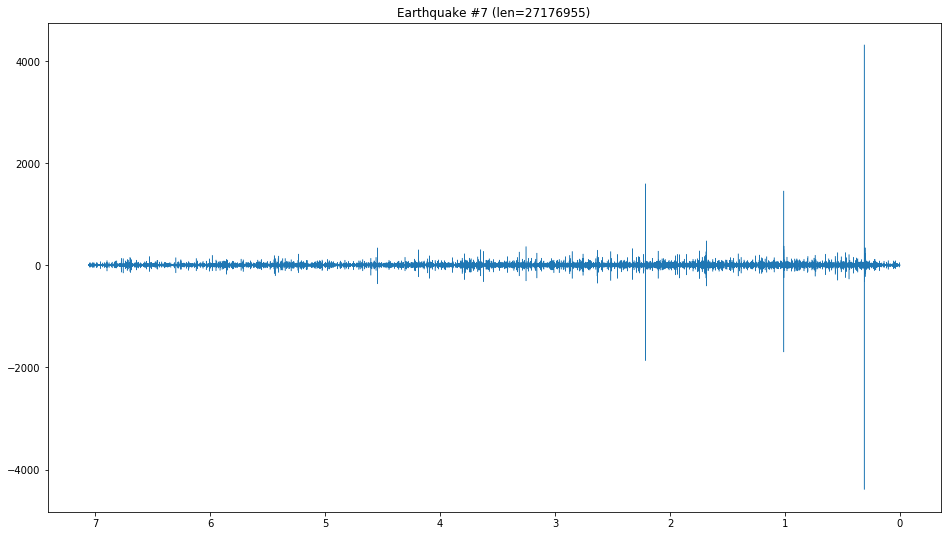

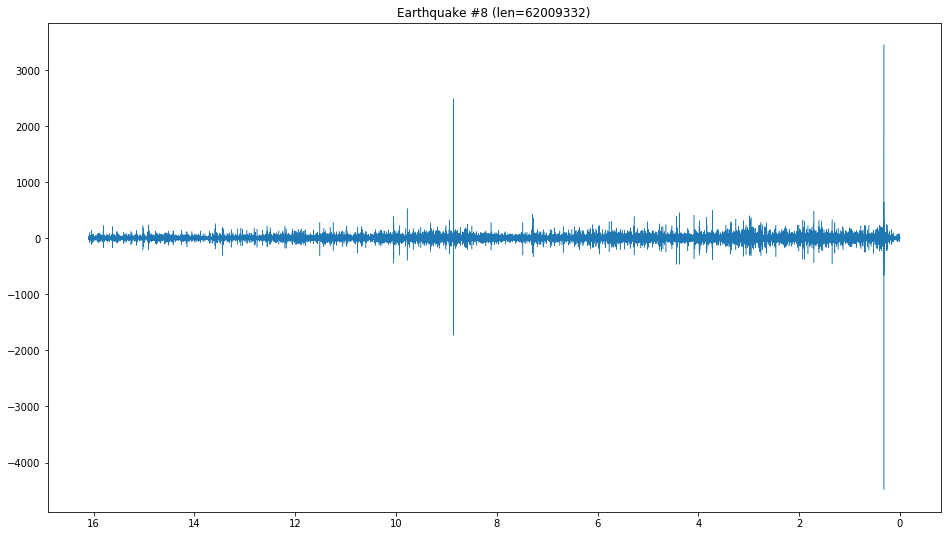

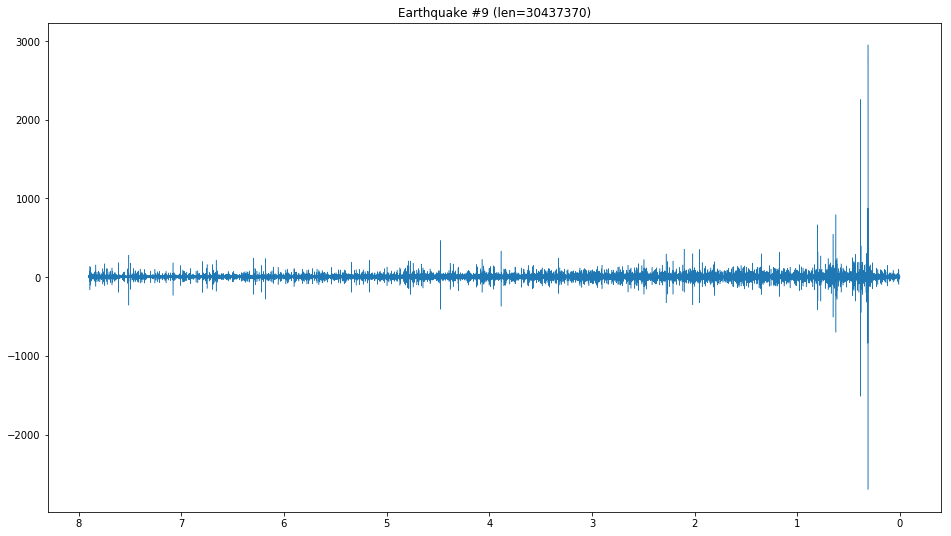

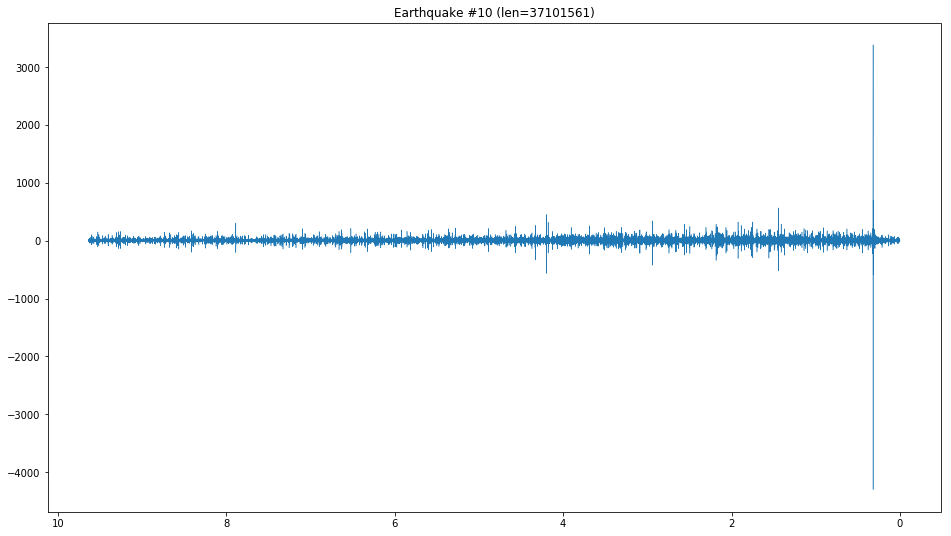

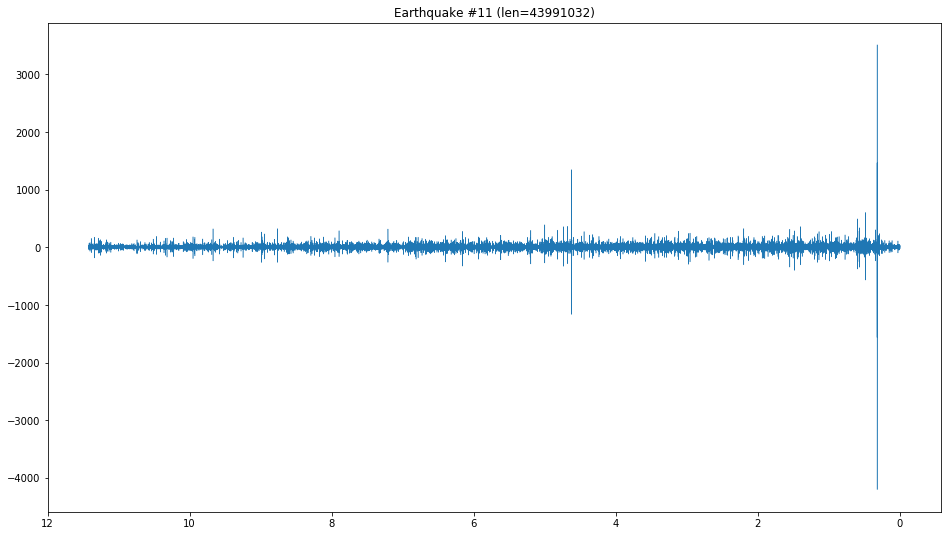

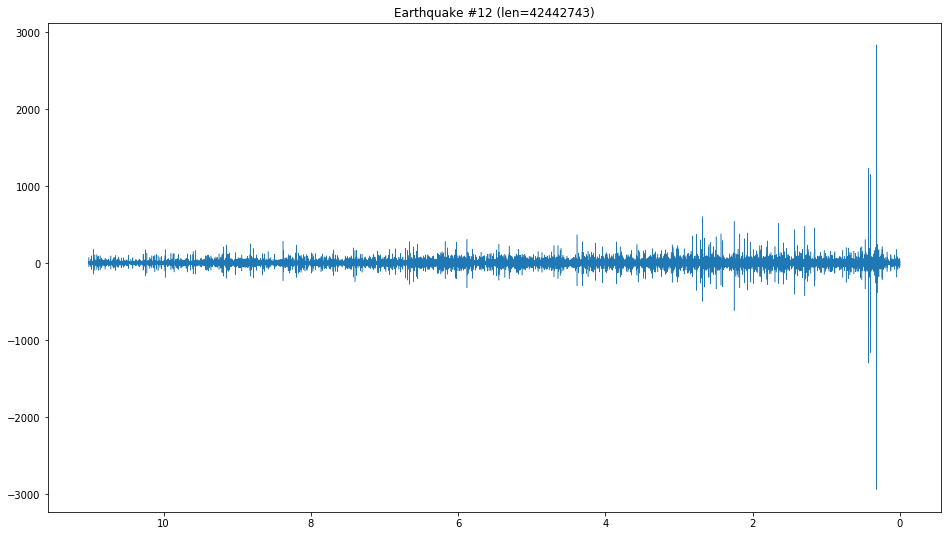

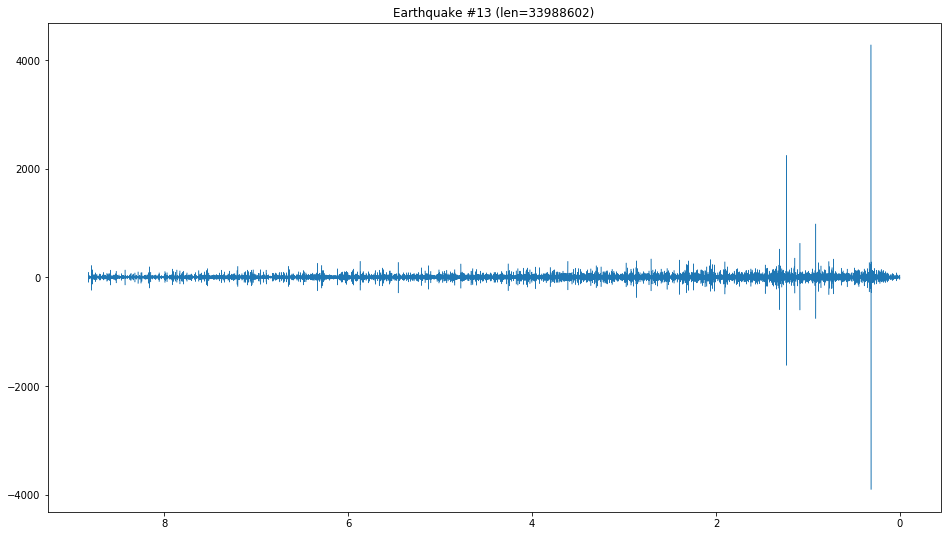

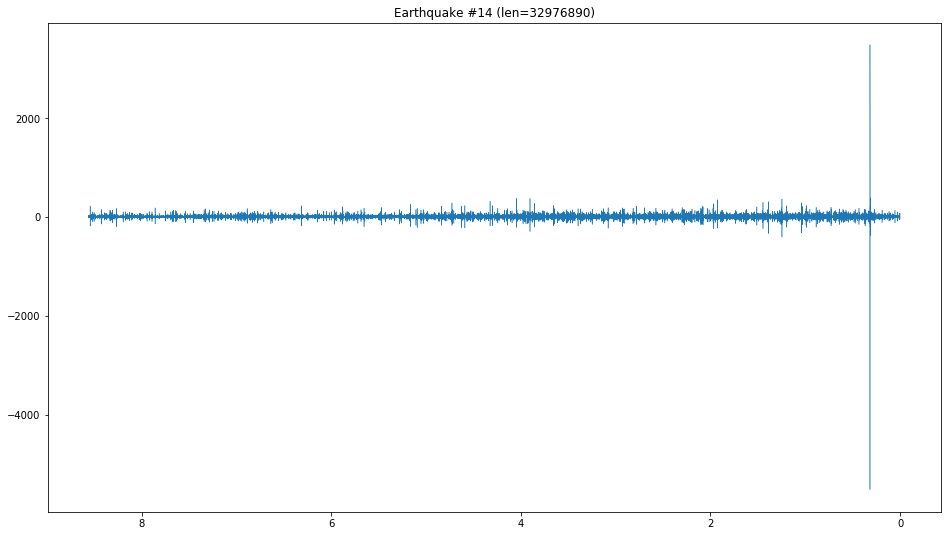

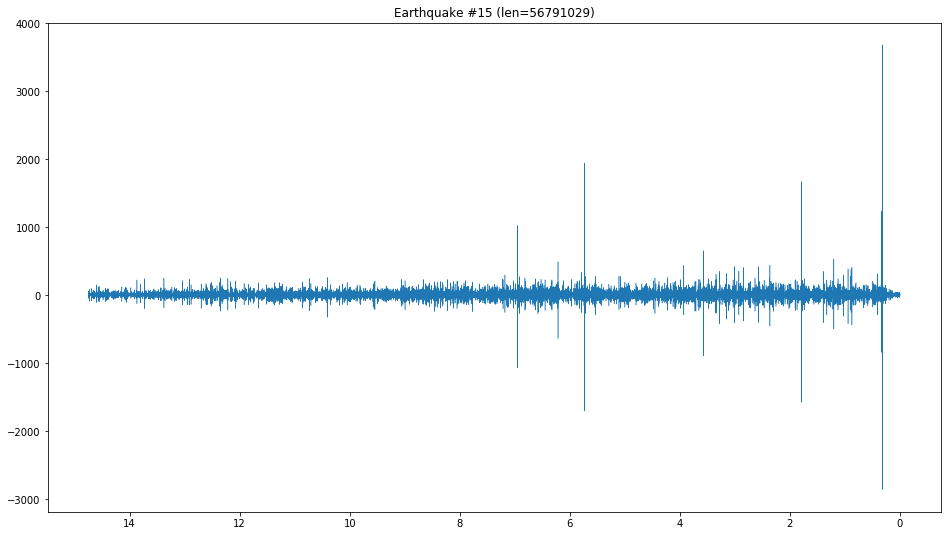

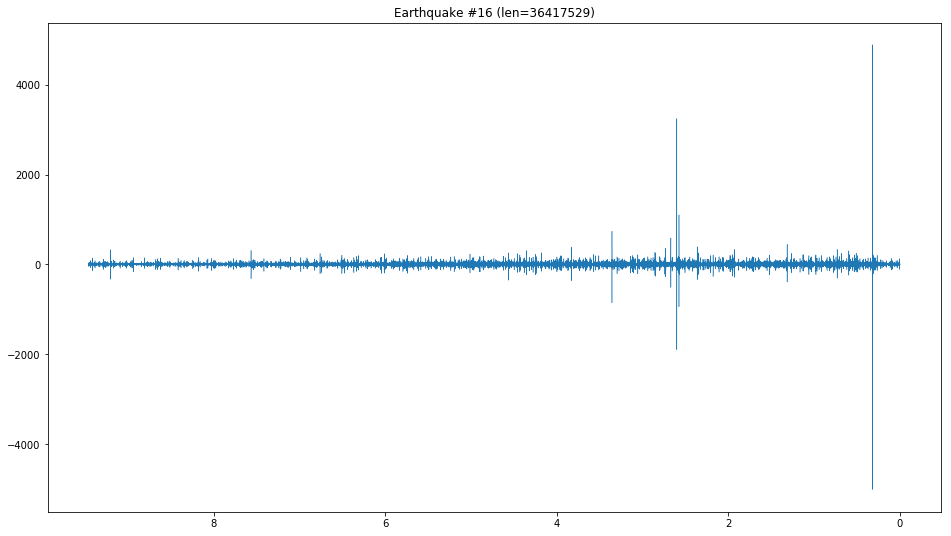

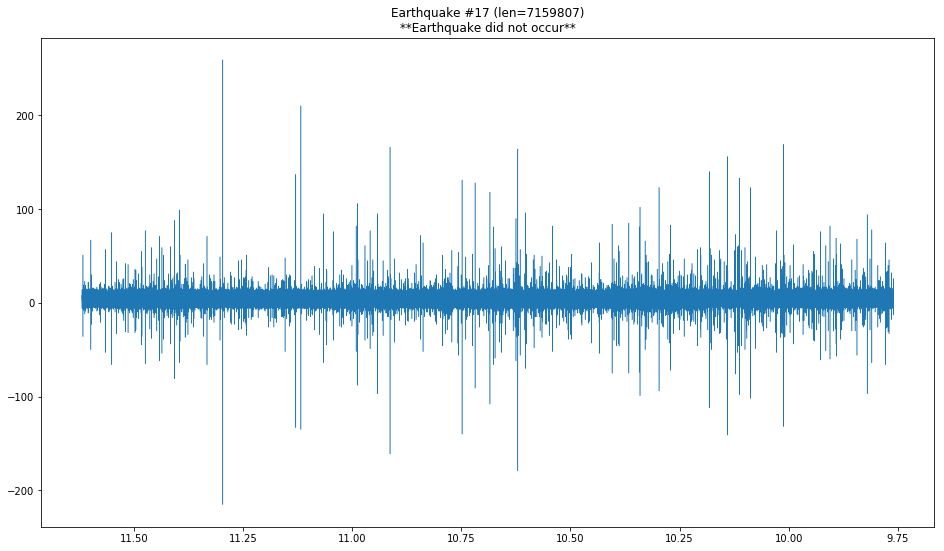

In [17]:
for quake_num, quake_start_end in enumerate(quake_indexes):
    quake_start = quake_start_end[0]
    quake_end = quake_start_end[1]
    quake_len = quake_end - quake_start
    title = 'Earthquake #%d (len=%d)' % (quake_num + 1, quake_end - quake_start)
    if quake_num == len(quake_indexes) - 1:
        title += '\n**Earthquake did not occur**'
    line_plot(quakes['time_to_failure'].iloc[quake_start:quake_end],
              quakes['acoustic_data'].iloc[quake_start:quake_end],
              title=title,
              reversex=True)

# To pickle, then to TFRecord

#### First, to pickle

In [5]:
PICKLE_DIR = '/workspace/persistent-data/earthquake/pickles'

In [7]:
!mkdir -p {PICKLE_DIR}

In [16]:
for quake_num, quake_start_stop in tqdm.tqdm(enumerate(quake_indexes), total=len(quake_indexes), ascii=True):
    quake_start = quake_start_stop[0]
    quake_end = quake_start_stop[1]
    quake_len = quake_end - quake_start
    out_pickle_fn = osp.join(PICKLE_DIR, '%d-%d.pickle' % (quake_num+1, quake_len))
    subdf = quakes.iloc[quake_start:quake_end]
    subdf.to_pickle(out_pickle_fn)

100%|##########| 17/17 [00:08<00:00,  1.95it/s]


In [6]:
!ls {PICKLE_DIR}

1-5656574.pickle    14-32976890.pickle	3-54591478.pickle  8-62009332.pickle
10-37101561.pickle  15-56791029.pickle	4-34095097.pickle  9-30437370.pickle
11-43991032.pickle  16-36417529.pickle	5-48869367.pickle
12-42442743.pickle  17-7159807.pickle	6-31010810.pickle
13-33988602.pickle  2-44429304.pickle	7-27176955.pickle


In [9]:
df = pd.read_pickle(osp.join(PICKLE_DIR, '1-5656574.pickle'))
df['acoustic_data'] = df['acoustic_data'].astype(np.float32)

In [24]:
len(df)

5656574

In [25]:
max(df['time_to_failure'])

1.4690999832

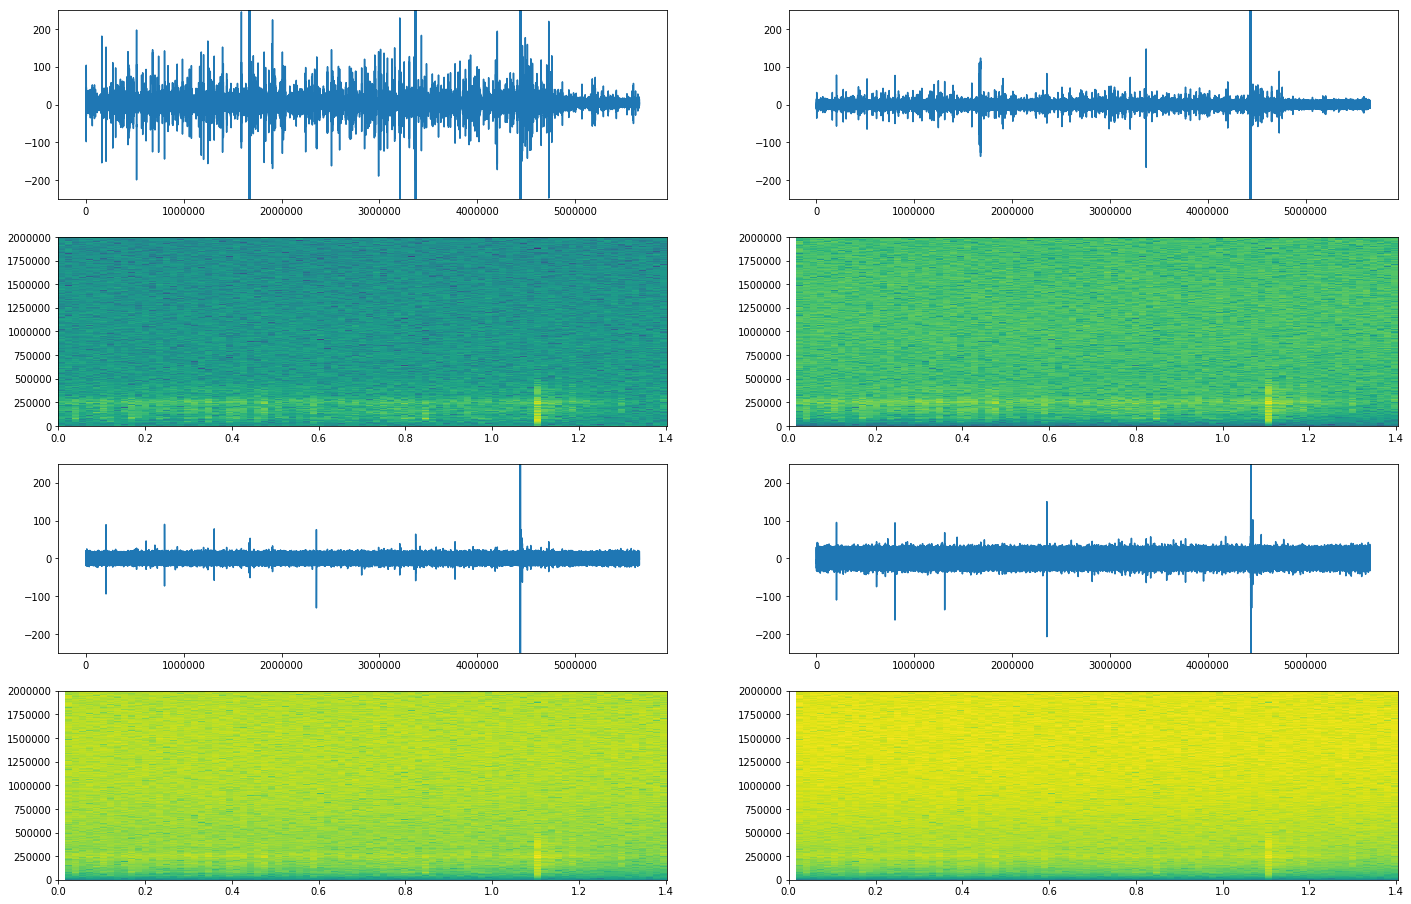

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(24,16))
dff = df['acoustic_data']
ax[0][0].plot(range(len(dff)), dff, ls='-')
ax[0][0].set_ylim([-250, 250])
specgram,_,_,_=ax[1][0].specgram(dff.values, NFFT=2**16, Fs=4000000, pad_to=2**16, noverlap=2**10)
#ax[1][0].set_ylim([0, 500])

dff = dff.diff()
ax[0][1].plot(range(len(dff)), dff, ls='-')
ax[0][1].set_ylim([-250, 250])
specgram,_,_,_=ax[1][1].specgram(dff.values, NFFT=2**16, Fs=4000000, pad_to=2**16, noverlap=2**10)
#ax[1][1].set_ylim([0, 500])

dff = dff.diff()
ax[2][0].plot(range(len(dff)), dff, ls='-')
ax[2][0].set_ylim([-250, 250])
_=ax[3][0].specgram(dff.values, NFFT=2**16, Fs=4000000, pad_to=2**16, noverlap=2**10)
#ax[3][0].set_ylim([0, 500])

dff = dff.diff()
ax[2][1].plot(range(len(dff)), dff, ls='-')
ax[2][1].set_ylim([-250, 250])
_=ax[3][1].specgram(dff.values, NFFT=2**16, Fs=4000000, pad_to=2**16, noverlap=2**10)
#ax[3][1].set_ylim([0, 500])

#### Now, to TFRecord

In [6]:
TFRECORD_DIR = '/workspace/persistent-data/earthquake/tfrecords5'

In [207]:
!rm -rf {TFRECORD_DIR} && mkdir -p {TFRECORD_DIR}

In [208]:
!ls -la {TFRECORD_DIR}

total 4
drwxr-xr-x.  2 root root   10 Mar 31 03:33 .
drwxr-xr-x. 13 root root 4096 Mar 31 03:33 ..


In [209]:
## TFRecord helper functions

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

# The following functions come from the TFRecords example [https://www.tensorflow.org/tutorials/load_data/tf-records]
# and a Float64 hack from https://github.com/tensorflow/tensorflow/issues/12876

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _float64_feature(value):
    """Returns a bytes_list of encoded float64"""
    value = [str(x).encode() for x in value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(acoustic_data, tminus):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    
    feature = {
        'acousticdata': _int64_feature(acoustic_data),
        'tminus': _float64_feature(tminus)
    }
    
    # Create a Features message using tf.train.Example.
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [210]:
def pickle_to_tfrecords(pick):
    
    RECS_PER_TFRECORD = 150000
    OVERLAP = 10000
    
    df = pd.read_pickle(pick)
    slug = osp.split(pick)[1].split('.')[0]
    
    start = 0
    finished = False
    while start < len(df) and not finished:
        
        end = start + RECS_PER_TFRECORD
        
        if end >= len(df):
            # we would have overflowed, write final segment (yes, we duplicate some overlap... oh well.)
            start = len(df) - RECS_PER_TFRECORD
            end = len(df)
            finished = True
        
        subdf = df.iloc[start:end]
        assert len(subdf) == RECS_PER_TFRECORD
        serex = serialize_example(subdf['acoustic_data'].values, subdf['time_to_failure'].values)
        
        outfn = osp.join(TFRECORD_DIR, '%s-start%d-end%d.tfrecord' % (slug, start, end))
        with tf.python_io.TFRecordWriter(outfn) as writer:
            writer.write(serex)
            
        start = start + OVERLAP
    
    print('finished processing: %s' % pick)

In [211]:
pickles = glob(osp.join(PICKLE_DIR, '*.pickle'))
print('\n'.join(['%d: %s' % (d, p) for d, p in enumerate(pickles)]))

0: /workspace/persistent-data/earthquake/pickles/1-5656574.pickle
1: /workspace/persistent-data/earthquake/pickles/2-44429304.pickle
2: /workspace/persistent-data/earthquake/pickles/3-54591478.pickle
3: /workspace/persistent-data/earthquake/pickles/4-34095097.pickle
4: /workspace/persistent-data/earthquake/pickles/5-48869367.pickle
5: /workspace/persistent-data/earthquake/pickles/6-31010810.pickle
6: /workspace/persistent-data/earthquake/pickles/7-27176955.pickle
7: /workspace/persistent-data/earthquake/pickles/8-62009332.pickle
8: /workspace/persistent-data/earthquake/pickles/9-30437370.pickle
9: /workspace/persistent-data/earthquake/pickles/10-37101561.pickle
10: /workspace/persistent-data/earthquake/pickles/11-43991032.pickle
11: /workspace/persistent-data/earthquake/pickles/12-42442743.pickle
12: /workspace/persistent-data/earthquake/pickles/13-33988602.pickle
13: /workspace/persistent-data/earthquake/pickles/14-32976890.pickle
14: /workspace/persistent-data/earthquake/pickles/15-5

In [212]:
def split_work_helper(q, do):
    while True:
        try:
            elem = q.get(timeout=0.5)
        except:
            break
        do(elem)

In [213]:
q = Queue(len(pickles))
n_procs = min(len(pickles), 28)
print('n_procs: %d' % n_procs)
for p in pickles:
    q.put(p)
processes = [Process(name=i, target=split_work_helper, args=(q, pickle_to_tfrecords)) for i in range(n_procs)]

n_procs: 17


In [214]:
print('[%s] qsize=%d' % (timestamp(), q.qsize()))

for p in processes:
    p.start()

while True:
    sz = q.qsize()
    print('[%s] qsize=%d' % (timestamp(), sz))
    if sz == 0:
        break
    time.sleep(10)

for p in processes:
    p.join()
    p.terminate()

print('[%s] operation completed successfully' % timestamp())

[2019-03-31 03:35:06] qsize=17
[2019-03-31 03:35:07] qsize=1
[2019-03-31 03:35:17] qsize=0
finished processing: /workspace/persistent-data/earthquake/pickles/1-5656574.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/17-7159807.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/7-27176955.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/9-30437370.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/6-31010810.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/14-32976890.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/13-33988602.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/4-34095097.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/10-37101561.pickle
finished processing: /workspace/persistent-data/earthquake/pickles/16-36417529.pickle
finished processing: /workspace/persistent-data/earthqua

## Val-*ish*-dation: compare pickle and TFrecord file sizes

In [215]:
!du -ks {PICKLE_DIR}
!du -ks {TFRECORD_DIR}

6144072	/workspace/persistent-data/earthquake/pickles
159367836	/workspace/persistent-data/earthquake/tfrecords5


In [216]:
!ls -l {PICKLE_DIR} | wc -l
!ls -l {TFRECORD_DIR} | wc -l

18
62685


# Check out file lengths, deltas in start position, etc.

In [217]:
tfrecs = glob(osp.join(TFRECORD_DIR, '*.tfrecord'))

In [218]:
dfrec = pd.DataFrame(columns=['filename'], data=tfrecs)

In [219]:
dfrec['start'] = dfrec['filename'].str.extract('start([0-9]+)').astype(int)

In [220]:
dfrec['end'] = dfrec['filename'].str.extract('end([0-9]+)').astype(int)

In [221]:
dfrec['l'] = dfrec['end'] - dfrec['start']

In [222]:
dfrec['l'].isnull().sum()

0

In [223]:
dfrec['l'].value_counts()

150000    62684
Name: l, dtype: int64

In [224]:
dfrec['quakenum'] = dfrec['filename'].str.extract('\/([0-9]+)\-').astype(int)

In [225]:
dfrec['quakenum'].value_counts().sort_index()

1      552
2     4429
3     5446
4     3396
5     4873
6     3088
7     2704
8     6187
9     3030
10    3697
11    4386
12    4231
13    3385
14    3284
15    5666
16    3628
17     702
Name: quakenum, dtype: int64

In [226]:
dfrec.groupby('quakenum')\
     .apply(lambda df: df.sort_values('start')['start'].diff().dropna())\
     .reset_index()['start']\
     .value_counts()

10000.0    62650
5097.0         1
8602.0         1
1032.0         1
9304.0         1
9332.0         1
9367.0         1
1561.0         1
7370.0         1
6890.0         1
6574.0         1
1478.0         1
9807.0         1
6955.0         1
810.0          1
7529.0         1
2743.0         1
1029.0         1
Name: start, dtype: int64

In [227]:
dfrec['quakelen'] = dfrec['filename'].str.extract('\/[0-9]+\-([0-9]+)\-').astype(int)

In [228]:
dfrec.groupby('quakelen').size()

quakelen
5656574      552
7159807      702
27176955    2704
30437370    3030
31010810    3088
32976890    3284
33988602    3385
34095097    3396
36417529    3628
37101561    3697
42442743    4231
43991032    4386
44429304    4429
48869367    4873
54591478    5446
56791029    5666
62009332    6187
dtype: int64

In [229]:
dfrec.head(3)

,filename,start,end,l,quakenum,quakelen
0,/workspace/persistent-data/earthquake/tfrecord...,0,150000,150000,7,27176955
1,/workspace/persistent-data/earthquake/tfrecord...,0,150000,150000,1,5656574
2,/workspace/persistent-data/earthquake/tfrecord...,0,150000,150000,9,30437370


In [230]:
dfrec = dfrec.sort_values(['quakenum', 'start']).reset_index(drop=True)

# Split into train/test

In [231]:
!mkdir -p {TFRECORD_DIR}/train
!mkdir -p {TFRECORD_DIR}/test
!rm -rf {TFRECORD_DIR}/train/*
!rm -rf {TFRECORD_DIR}/test/*

In [232]:
TEST_PCT = 0.1

In [238]:
def mark_train_test(quakedf):
    quakedf = quakedf.sort_values('start').reset_index(drop=True)
    quakedf['inval'] = False
    quakedf['test'] = False
    
    overlaps = int(150000 / 10000)
    test_take = int(TEST_PCT / (overlaps * 2) * len(quakedf))
    test_idx = np.random.permutation(len(quakedf))[:test_take]
    print(test_idx)
    
    for idx in test_idx:
        start = idx - overlaps + 1
        end = idx + overlaps
        inval_start = idx - (2 * overlaps) + 2
        inval_end = idx + (2 * overlaps) - 1

        quakedf.loc[inval_start:start, 'inval'] = True
        quakedf.loc[start:end, 'test'] = True
        quakedf.loc[end:inval_end, 'inval'] = True
    
    return quakedf

In [239]:
ttdf = dfrec.groupby('quakenum', as_index=False).apply(mark_train_test)

[141]
[12]
[3755 3528 3961   87 3800   84 4386  729  897 3969 1379 2289 3680 3596]
[3279 5385 4577  819 2501 3675  823 4300 5289 3439 4364  279 4484 2734
 4135 4490 1601 2711]
[1710 1492  807  863 2246  829 2818  726 2400 3268  842]
[ 771 1738 2826 3707 1590  446  214 3764 2096  894 3118 4543 2155 1442
 1550   71]
[ 853 2490 1366 2728 2351  968 1689  637 2429 2872]
[1342 1701  144 2539 2230 2236  265  628 1763]
[2388  570 4157 3110  587 5962 2753 2370 4567 2888 2603 2293 4989 1363
  552 2357  958 4963 1031 4247]
[1595  276 2107  442  707 2041 2144 1976 1472  504]
[ 892 2497  796 1322 1620  950  113 1797   28  617  847 3655]
[2605 2729 3178 2515 2107  442 3499 4283 2541 3515 1380 2763  333 3596]
[1915  252 3870 3435 3877 3059 1545 2701  607  255 3916 4145  159  176]
[ 324  249  834 2394 1738 2853  786 3308 1985 1824 2581]
[2608 1837 3247  995  935 1662 2492 3020 1097 1922]
[4892 4241 1760 4440 4734 5404 2898 3096 2060   91  159 3270 4594 4457
 1316 1515 3078 5323]
[3620 2392 1577 3373  

## Check invalidated dataset proportion

In [240]:
ttdf['inval'].sum() / len(ttdf)

0.0918735243443303

## Check test set data proportion

In [241]:
ttdf['test'].sum() / len(ttdf)

0.09093229532257036

## Check train set data proportion

In [242]:
ttdf['train'] = ttdf.apply(lambda x: not x['test'] and not x['inval'], axis=1)

In [243]:
ttdf['train'].sum() / len(ttdf)

0.8320145491672516

In [244]:
assert len(ttdf) == len(dfrec)

In [245]:
for f in ttdf[ttdf['test'] == True]['filename'].values:
    shutil.move(f, osp.join(TFRECORD_DIR, 'test'))

In [246]:
for f in ttdf[ttdf['train'] == True]['filename'].values:
    shutil.move(f, osp.join(TFRECORD_DIR, 'train'))

In [247]:
ttdf[ttdf['inval'] & ttdf['test']].shape

(929, 9)

In [248]:
for f in ttdf[(ttdf['inval'] == True) & (ttdf['test'] == False)]['filename'].values:
    try:
        os.remove(f)
    except:
        pass

In [249]:
!ls {TFRECORD_DIR} | wc -l

2


In [250]:
!ls {osp.join(TFRECORD_DIR, 'train')} | wc -l

52154


In [251]:
!ls {osp.join(TFRECORD_DIR, 'test')} | wc -l

5700


In [252]:
ttdf['train'].sum()

52154

In [253]:
ttdf['test'].sum()

5700

## Give them random IDs so that lexicographical ordering doesn't have any pattern

In [254]:
for traintest in ['train', 'test']:
    for f in glob(osp.join(TFRECORD_DIR, traintest, '*.tfrecord')):
        shutil.move(f, osp.join(osp.split(f)[0], str(np.random.randint(low=11111111111,
                                                                       high=99999999999)) + '-' + osp.split(f)[1]))

In [255]:
!ls {osp.join(TFRECORD_DIR, 'train')} | wc -l

52154


In [256]:
!ls {osp.join(TFRECORD_DIR, 'test')} | wc -l

5700
